In [2]:
# Imports
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf


from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

In [3]:
# Using GPU on local machine, comment this out if you are using CPU

# Avoid OOM errors by limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU
Physical devices cannot be modified after being initialized


In [4]:
# Check for available GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Directory paths to use
TRAIN_IMG_PATH = '../data/train/'
TEST_IMG_PATH = '../data/test/'
TRAIN_ANNOTATION_PATH = '../data/train.csv'
TEST_PREDICTIONS_PATH = '../data/submission.csv'
MODEL_PATH = '../models/'
LOG_PATH = '../logs/'

In [9]:
# Number of images for training and test sets
train_img_numk = len([entry for entry in os.listdir(TRAIN_IMG_PATH) if os.path.isfile(os.path.join(TRAIN_IMG_PATH, entry))])
test_img_num = len([entry for entry in os.listdir(TEST_IMG_PATH) if os.path.isfile(os.path.join(TEST_IMG_PATH, entry))])

print('Number of training images: ', str(train_img_num))
print('Number of test images: ', str(test_img_num))


Number of training images:  18618
Number of test images:  43442


In [10]:
# Read and preview annotation into data frame
df = pd.read_csv(TRAIN_ANNOTATION_PATH)
print(f'Number of records: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
df.head()

Number of records: 18618
Number of columns: 2


,id,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,0
4,4.jpg,1


In [11]:
# Counts for each prediction class
df.value_counts('label')

label
1    10330
0     8288
dtype: int64

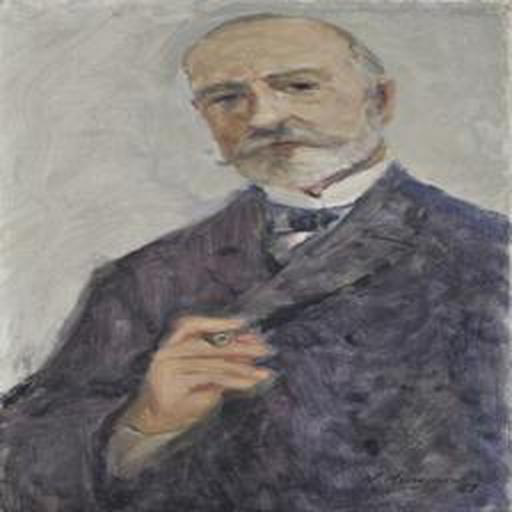

In [12]:
# Preview an image
images = os.listdir(TRAIN_IMG_PATH)
PIL.Image.open(TRAIN_IMG_PATH + str(images[5]))

In [13]:
# Replace binary labels with strings
df.label.replace({0: 'AI Generated', 1: 'Real'}, inplace=True)
df.head(20)

,id,label
0,0.jpg,Real
1,1.jpg,Real
2,2.jpg,Real
3,3.jpg,AI Generated
4,4.jpg,Real
5,5.jpg,Real
6,6.jpg,Real
7,7.jpg,AI Generated
8,8.jpg,Real
9,9.jpg,Real


In [14]:
# Define some parameters for the Keras data loader and model
batch_size = 32
img_height = 180
img_width = 180
seed = 42
num_classes = 2
epochs = 10


In [15]:
# Preprocess image data located in directory with labels in separate .csv file and split into training, validation, and testing datasets
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(dataframe=df, 
                                            directory=TRAIN_IMG_PATH,
                                            x_col="id",
                                            y_col="label",
                                            subset='training',
                                            class_mode="categorical",
                                            target_size=(img_height, img_width),
                                            batch_size=batch_size,
                                            seed=seed,
                                            shuffle=True)
                                            
valid_generator=datagen.flow_from_dataframe(dataframe=df, 
                                            directory=TRAIN_IMG_PATH,
                                            x_col="id",
                                            y_col="label",
                                            subset='validation',
                                            class_mode="categorical",
                                            target_size=(img_height, img_width),
                                            batch_size=batch_size,
                                            seed=seed,
                                            shuffle=True)                                        

Found 13964 validated image filenames belonging to 2 classes.
Found 4654 validated image filenames belonging to 2 classes.


In [16]:
# Build model

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizers.RMSprop(),
loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
# Initiate Tensorboard for logging during model training
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_PATH)

In [18]:
# Train Model

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

/home/edimeo/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
436/436 [==============================] - 78s 161ms/step - loss: 0.4377 - accuracy: 0.7976 - val_loss: 0.2911 - val_accuracy: 0.8664
Epoch 2/10
436/436 [==============================] - 95s 217ms/step - loss: 0.3000 - accuracy: 0.8676 - val_loss: 0.2627 - val_accuracy: 0.8914
Epoch 3/10
436/436 [==============================] - 90s 207ms/step - loss: 0.2649 - accuracy: 0.8852 - val_loss: 0.2476 - val_accuracy: 0.8901
Epoch 4/10
436/436 [==============================] - 90s 207ms/step - loss: 0.2406 - accuracy: 0.9011 - val_loss: 0.2577 - val_accuracy: 0.8963
Epoch 5/10
436/436 [==============================] - 94s 215ms/step - loss: 0.2268 - accuracy: 0.9033 - val_loss: 0.2312 - val_accuracy: 0.8981
Epoch 6/10
436/436 [==============================] - 94s 215ms/step - loss: 0.2192 - accuracy: 0.9122 - val_loss: 0.2695 - val_accuracy: 0.8881
Epoch 7/10
436/436 [==============================] - 98s 224ms/step - loss: 0.2026 - accuracy: 0.9168 - val_loss: 0.2231 - val_ac

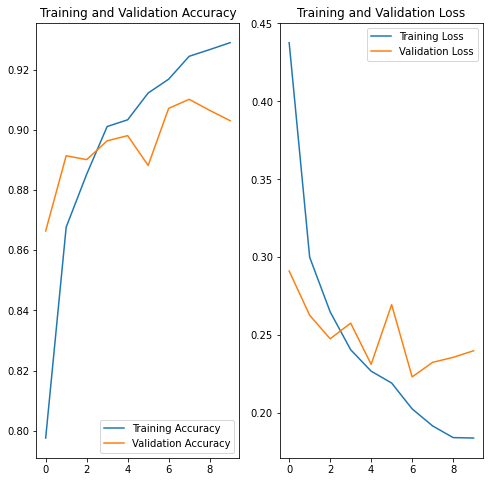

In [19]:
# Create plots of the loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

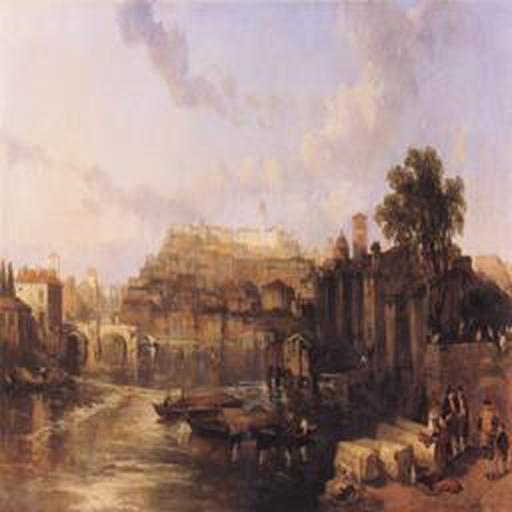

In [20]:
# Preview a test image before predictions
test_images = os.listdir(TEST_IMG_PATH)
test_image_path = TEST_IMG_PATH + str(test_images[50])
PIL.Image.open(test_image_path)

In [21]:
# Predict on new data

img = tf.keras.utils.load_img(
    test_image_path, 
    target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['AI Generated', 'Real']

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to AI Generated with a 73.11 percent confidence.


In [23]:
# Save Model
from tensorflow.keras.models import load_model

model.save(os.path.join(MODEL_PATH, 'tf_model_20230129.h5'))

In [33]:
# Load saved model
loaded_model = load_model(MODEL_PATH + 'tf_model_20230129.h5')